# Demonstration for setting up an ODE system

PyGOM — A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

Using PyGOM, we will set up a simple SEIR model. This model has many simplifying assumptions, including:
- no births or deaths
- homogeneous mixing
- no interventions

Suscebtible population (S) are those that can catch the disease. A susceptible person becomes infected when they interact with an infected person. The chance of this interaction resulting in infection is described with parameter $\beta$.

$ \frac{dS}{dt} = -\beta S \frac{I}{N}$ 

Exposed population (E) are those that have contracted the disease but are not yet infetious. They become infectious with rate $\alpha$. 

$ \frac{dE}{dt} = \beta S \frac{I}{N} - \alpha E$

Infected population (I) recover at rate $\gamma$.

$ \frac{dI}{dt} = \alpha E - \gamma I$

Removed population (R) are those who have immunity (described with initial conditions) or have recovered/died from the disease.

$ \frac{dR}{dt} = \gamma I$

Total population (N) is given by $N = S + E + I + R$.


In [1]:
# import required packages
from pygom import DeterministicOde, Transition, SimulateOde, TransitionType

import os 
from sympy import symbols, init_printing
import numpy as np
import matplotlib.pyplot as mpl
import sympy
import itertools

In [ ]:
# Add graphvis path (N.B. set to your local circumstances)
graphvis_path = 'h:\\Programs\\Graphvis-2.38\\bin\\'
if not graphvis_path in os.environ['PATH']:
    os.environ['PATH'] = os.environ['PATH'] + ';' + graphvis_path

In [2]:
def  print_ode2(self):
        '''
        Prints the ode in symbolic form onto the screen/console in actual
        symbols rather than the word of the symbol.
        
        Based on the PyGOM built-in but adapted for Jupyter
        '''
        A = self.get_ode_eqn()
        B = sympy.zeros(A.rows,2)
        for i in range(A.shape[0]):
            B[i,0] = sympy.symbols('d' + str(self._stateList[i]) + '/dt=')
            B[i,1] = A[i]

        return B

In [3]:
# set up the symbolic SEIR model

state = ['S', 'E', 'I', 'R']
param_list = ['beta', 'alpha', 'gamma', 'N']

# Equations can be set up in a variety of ways; either by providing the equations for each state individually,
# or listing the transitions (shown here).

transition = [
    Transition(origin='S', destination='E', equation='beta*S*I/N',
               transition_type=TransitionType.T),
    Transition(origin='E', destination='I', equation='alpha*E',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='R', equation='gamma*I',
               transition_type=TransitionType.T)
    ]

SEIR_model = DeterministicOde(state, param_list, transition=transition)

In [4]:
# display equations
print_ode2(SEIR_model)

Matrix([
[dS/dt=,           -I*S*beta/N],
[dE/dt=, -E*alpha + I*S*beta/N],
[dI/dt=,     E*alpha - I*gamma],
[dR/dt=,               I*gamma]])

In [ ]:
# display graphical representation of the model
#SEIR_model.get_transition_graph()

The following parameterization, run over 100 days, results in an infection rate of approximately 60%. 

The disease has a latent period of 2 days ($1/\alpha$), and individuals are infectious for 1 day ($1/\gamma$).

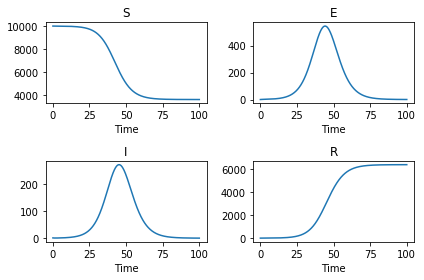

Peak infection (days) 45.2
R0 (beta/gamma) =  1.6


In [5]:
# provide parameters

t = np.linspace(0, 100, 1001)

# initial conditions
# for a population of 10000, one case has presented, and we assume there is no natural immunity
x0 = [9999.0, 0.0, 1, 0.0]

# latent for 2 days
# ill for 1 day
params = {'beta': 1.6,
          'alpha': 0.5, 
          'gamma': 1,
          'N': sum(x0)}

SEIR_model.initial_values = (x0, t[0])
SEIR_model.parameters = params
solution = SEIR_model.integrate(t[1::])
SEIR_model.plot()

# calculate time point when maximum number of people are infectious
peak_i = np.argmax(solution[:,2])
print('Peak infection (days)', t[peak_i])

# calculate reproductive number R0
print('R0 (beta/gamma) = ', params['beta']/params['gamma'])

In [16]:
solution[:,0]


array([ 9999.        ,  9998.84755578,  9998.70849321, ...,  3579.95041175,
        3579.94090247,  3579.93154352])

In [6]:
# function for altering parameters
model = DeterministicOde(state, param_list, transition=transition)
def parameterize_model(t=np.linspace(0,100,1001), beta=1.6, alpha=0.5, gamma=1, ic=[9999, 0, 1, 0], model=model):
    params = {'beta': beta,
              'alpha': alpha, 
              'gamma': gamma,
              'N': sum(ic)}
    model.initial_values = (ic, t[0])
    model.parameters = params
    sol = model.integrate(t[1::])
    model.plot()
    peak_i = np.argmax(sol[:,2])
    print('Peak infection (days)', t[peak_i] )
    print('R0 (beta/gamma) = ', params['beta']/params['gamma'])
    

In this simple framework, reducing $\beta$ results in a smaller epidemic:
- the peak infection time is delayed
- the magnitude of peak infection is reduced.

Reducing beta may crudely represent giving out anti-virals, which make a person less infectious.

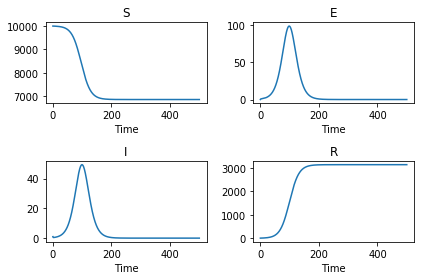

Peak infection (days) 99.4
R0 (beta/gamma) =  1.2


In [7]:
parameterize_model(beta=1.2, t=np.linspace(0,500,5001))

Vaccinating 5% of the population (assuming instantaneous rollout) or natural immunity, delays the peak period, and reduces its magnitude.

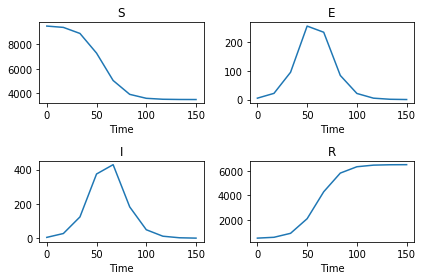

Peak infection (days) 66.6666666667
R0 (beta/gamma) =  1.6666666666666667


In [11]:
parameterize_model(ic=[9490,5, 5, 500], beta=0.5, gamma=0.3, t=np.linspace(0,150,10))